In [1]:
import geopandas as gpd
import ipaddress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
import shapely
import shapely.geometry
import shapely.wkt
import yaml
import time
from tqdm.auto import tqdm
import os
from pathlib import Path
from dateutil.relativedelta import relativedelta

from datetime import date, datetime, timedelta, timezone
from shapely import Point, Polygon, MultiPolygon, GeometryCollection, Geometry
from typing import Tuple, Union

from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from aimlsse_api.data import *

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [2]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [3]:
target_state = 'Texas'

In [4]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir]:
    os.makedirs(dir, exist_ok=True)
server_ip = '141.52.225.23'
# server_ip = '127.0.0.1'

In [5]:
datetime_to = datetime.now(tz=timezone.utc).date()
datetime_to = datetime(datetime_to.year, datetime_to.month, datetime_to.day)
assert isinstance(datetime_to, datetime)
datetime_from = datetime_to - relativedelta(months=6)
# datetime_from = datetime(2022, 8, 1)
assert datetime_to.date() > datetime_from.date(), f'Dates must be strictly ordered + \
    \nfrom:\t{datetime_from.date()}\nto:\t{datetime_to.date()}'
print(f'From\t{datetime_from}\nTo\t{datetime_to}')

From	2022-12-23 00:00:00
To	2023-06-23 00:00:00


In [6]:
station_radius_of_influence = 16000.0 # meters

In [7]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

<class 'shapely.geometry.multipolygon.MultiPolygon'>


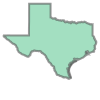

In [8]:
area_of_interest: Union[Polygon, MultiPolygon] = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [9]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

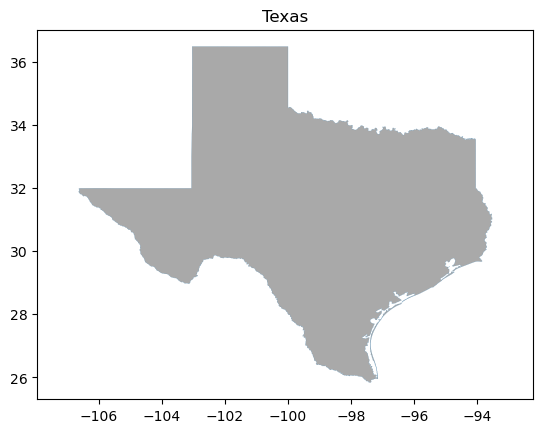

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
plot_area_of_interest(ax, 'darkgray')

In [11]:
ground_client = GroundDataClient(ipaddress.ip_address(server_ip), 8000)
stations_metadata_filepath = os.path.join(preprocessing_dir, 'station_metadata.csv')
recreate_station_metadata = False
if os.path.exists(stations_metadata_filepath) and not recreate_station_metadata:
    stations_metadata = pd.read_csv(stations_metadata_filepath, index_col=0)
    stations_metadata['geometry'] = stations_metadata['geometry'].apply(shapely.from_wkt)
    stations_metadata = gpd.GeoDataFrame(stations_metadata)
    stations_metadata.set_crs(epsg=4326, inplace=True)
else:
    if isinstance(area_of_interest, Polygon):
        query_polygons = [area_of_interest]
    else:
        query_polygons = list(area_of_interest.geoms)
    stations_metadata = ground_client.queryMetadata(polygons=query_polygons)
    stations_metadata['name'] = stations_metadata['id']
    stations_metadata.set_index('id', inplace=True)
    stations_metadata.to_csv(stations_metadata_filepath)
print(f'Found {len(stations_metadata.index)} stations')

Found 5144 stations


In [12]:
def plot_stations(ax:plt.Axes, color:str):
    stations_metadata.plot(ax=ax, marker='.', color=color, markersize=1)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'Station-coverage of Texas'}>

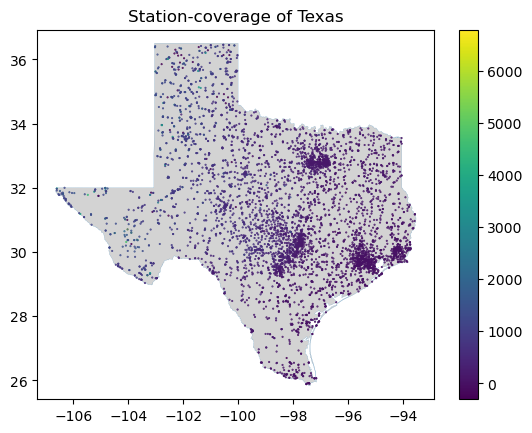

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
stations_metadata.plot('elevation', ax=ax, marker='.', markersize=1, colormap='viridis', legend=True)

In [14]:
satellite_client = SatelliteDataClient(ipaddress.ip_address(server_ip), 8010)
stations_to_sentinel_grid_cells_mapping: gpd.GeoDataFrame = satellite_client.queryContainingGeometry(
    stations_metadata[['name', 'geometry']])
sentinel_grid_cells: gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping.drop_duplicates(subset=['cell_name']).copy()
print(f'Found {len(sentinel_grid_cells.index)} grid-cells')

Found 102 grid-cells


In [15]:
def plot_grid_cells(ax:plt.Axes):
    sentinel_grid_cells['geometry'].buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.5, linewidth=0.8, zorder=2)

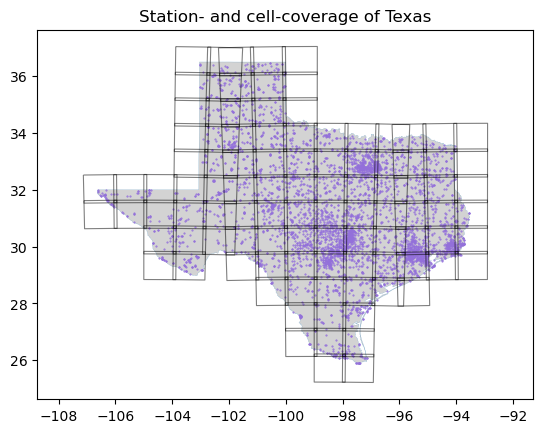

In [16]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station- and cell-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
plot_stations(ax, 'mediumpurple')
plot_grid_cells(ax)

In [17]:
stations_per_grid_cell = stations_to_sentinel_grid_cells_mapping.groupby('cell_name')['name']
print(f'Average number of stations per grid cell: {stations_per_grid_cell.count().mean()}')

Average number of stations per grid cell: 62.0


In [18]:
sentinel_products_metadata_filepath = os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv')
os.makedirs(os.path.dirname(sentinel_products_metadata_filepath), exist_ok=True)
recreate_sentinel_products = False
if not recreate_sentinel_products and os.path.exists(sentinel_products_metadata_filepath):
    sentinel_products_metadata = pd.read_csv(sentinel_products_metadata_filepath, index_col=0)
else:
    sentinel_products_metadata_list = []
    for cell_name in sentinel_grid_cells['cell_name']:
        sentinel_products_metadata_list += [satellite_client.queryProductsMetadata(datetime_from, datetime_to, copernicus_login,
            cell_name=cell_name
        )]
        time.sleep(1)
    sentinel_products_metadata = pd.concat(sentinel_products_metadata_list)
    sentinel_products_metadata.drop_duplicates(inplace=True)
    sentinel_products_metadata.to_csv(sentinel_products_metadata_filepath)
sentinel_products_metadata['footprint'] = sentinel_products_metadata['footprint'].apply(lambda x: shapely.from_wkt(x))
sentinel_products_metadata['geometry'] = sentinel_products_metadata['footprint']
sentinel_products_metadata = gpd.GeoDataFrame(sentinel_products_metadata)
sentinel_products_metadata.set_crs(epsg=4326, inplace=True)
sentinel_products_metadata = sentinel_products_metadata[sentinel_products_metadata['tileid'].isin(sentinel_grid_cells['cell_name'])]
print(f'Found {len(sentinel_products_metadata.index)} entries')

Found 4645 entries


In [19]:
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)

In [20]:
sentinel_products_metadata[date_columns]

,beginposition,endposition,generationdate,ingestiondate
6607186c-8cbb-45df-a701-4fad4bfe2b24,2023-06-17 17:39:11.024000+00:00,2023-06-17 17:39:11.024000+00:00,2023-06-17 22:56:38+00:00,2023-06-18 01:39:50.835000+00:00
a9464886-8b2e-41d1-af9c-b5732ed74fcc,2023-06-12 17:39:09.024000+00:00,2023-06-12 17:39:09.024000+00:00,2023-06-12 21:06:23+00:00,2023-06-12 23:33:36.482000+00:00
995e6912-28aa-4ee1-ae02-4460dc0ea8f8,2023-06-07 17:39:11.024000+00:00,2023-06-07 17:39:11.024000+00:00,2023-06-07 22:40:34+00:00,2023-06-08 01:58:48.780000+00:00
988f7390-5137-4301-9de5-5186c5303c7f,2023-06-02 17:39:09.024000+00:00,2023-06-02 17:39:09.024000+00:00,2023-06-02 21:06:30+00:00,2023-06-02 23:28:46.834000+00:00
710d2100-227f-483d-baa9-469f4fa4bcb5,2023-05-28 17:39:11.024000+00:00,2023-05-28 17:39:11.024000+00:00,2023-05-28 22:42:14+00:00,2023-05-29 02:00:27.567000+00:00
...,...,...,...,...
ec4b2094-3738-4f8e-bd06-35553da75a1a,2023-01-08 16:56:59.024000+00:00,2023-01-08 16:56:59.024000+00:00,2023-01-08 18:51:40+00:00,2023-01-08 20:36:18.638000+00:00
ecc9515a-337b-4ebd-aa89-ad39a5f56b6b,2023-01-03 16:57:11.024000+00:00,2023-01-03 16:57:11.024000+00:00,2023-01-03 18:52:20+00:00,2023-01-03 21:28:28.108000+00:00
c15da37a-74d7-4252-a12c-6950c964d072,2022-12-29 16:57:19.024000+00:00,2022-12-29 16:57:19.024000+00:00,2022-12-29 18:51:52+00:00,2022-12-29 20:41:02.476000+00:00
e490676e-2dd1-4d46-92c6-3a32d353b35d,2022-12-24 16:57:21.024000+00:00,2022-12-24 16:57:21.024000+00:00,2022-12-24 18:52:19+00:00,2022-12-24 21:00:48.277000+00:00


In [21]:
sentinel_products_metadata_per_cell = sentinel_products_metadata.groupby(['tileid'])
sentinel_grid_cells['num_entries'] = sentinel_grid_cells['cell_name'].apply(
    lambda name: len(sentinel_products_metadata_per_cell.get_group(name)) if name in sentinel_products_metadata_per_cell.groups else 0
)

<Axes: ylabel='Frequency'>

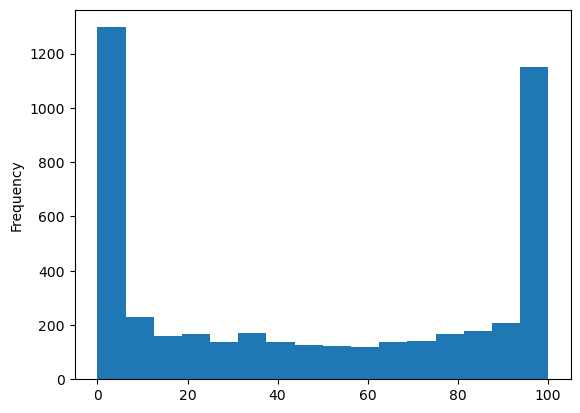

In [22]:
sentinel_products_metadata['cloudcoverpercentage'].plot.hist(bins=16)

<Axes: title={'center': 'Number of sentinel-products per cell'}>

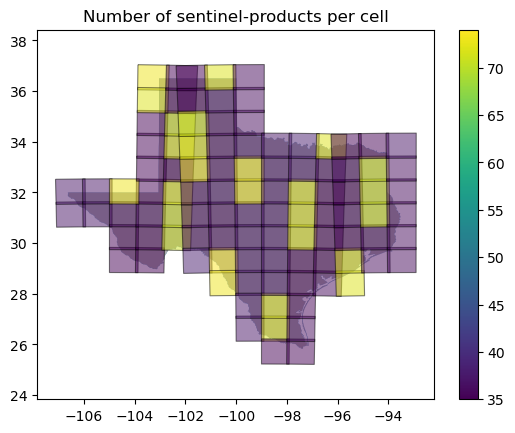

In [23]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Number of sentinel-products per cell')
plot_area_of_interest(ax, 'darkgray')
sentinel_grid_cells.plot('num_entries', ax=ax, markersize=0, edgecolor='black', facecolor='red',
    alpha=0.5, linewidth=0.8, legend=True, zorder=2)

In [24]:
products_sorted = sentinel_products_metadata.sort_values(by=['cloudcoverpercentage', 'beginposition'], ascending=[False, True])
products_range_selection = products_sorted[(products_sorted['cloudcoverpercentage'] < 30) | (products_sorted['cloudcoverpercentage'] > 70)].copy()
products_range_selection = products_sorted
print(f'After selection, {len(products_range_selection.index)} of {len(sentinel_products_metadata.index)} products remain')

After selection, 4645 of 4645 products remain


In [25]:
products_range_selection['geometry'] = products_range_selection['footprint']
remaining_grid_cells = products_range_selection.groupby(['tileid'])
print(f'After selection {len(remaining_grid_cells)} of {sentinel_grid_cells.shape[0]} grid cells remain')

After selection 102 of 102 grid cells remain


C:\Users\erikw\AppData\Local\Temp\ipykernel_16468\3631072304.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, data in remaining_grid_cells:


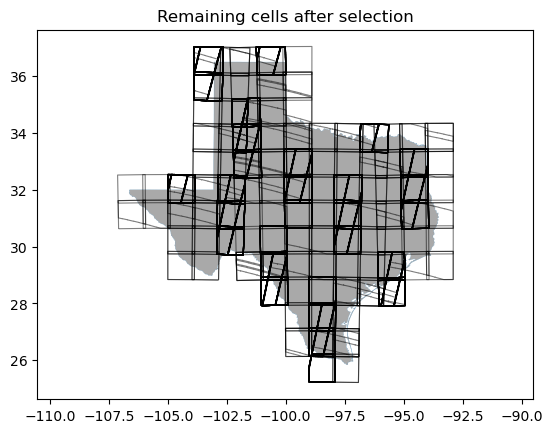

In [26]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Remaining cells after selection')
plot_area_of_interest(ax, 'darkgray')
for label, data in remaining_grid_cells:
    gpd.GeoDataFrame(data.drop_duplicates(subset=['geometry'])).plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.5, linewidth=0.8, zorder=2)

In [27]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [28]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [29]:
products_range_selection['beginposition']

c1992103-4732-43d6-90ee-b093be6039ba   2022-12-19 16:57:19.024000+00:00
438e3916-9e08-4426-9836-300754627549   2022-12-19 16:57:19.024000+00:00
2f6ba1de-d2b2-411b-aaca-359933cc203c   2022-12-22 17:07:29.024000+00:00
a38fe759-525f-4c31-b252-5df24a64cd9a   2022-12-22 17:07:29.024000+00:00
c1f708f3-b4ff-40c2-bba0-23f9918963a4   2022-12-22 17:07:29.024000+00:00
                                                     ...               
e5b84f70-f626-40a8-906b-0c808cbd287f   2023-06-18 17:09:01.024000+00:00
6cce5e6e-d6d0-432a-89a0-4737c61cadd6   2023-06-18 17:09:01.024000+00:00
1885c035-6699-43dc-ae2f-92404e7a15be   2023-06-18 17:09:01.024000+00:00
cfe9741f-1740-4737-9d11-ff4aae092466   2023-06-18 17:09:01.024000+00:00
bec26bb7-495e-418d-98bd-86ab85f059c5   2023-06-18 17:09:01.024000+00:00
Name: beginposition, Length: 4645, dtype: datetime64[ns, UTC]

In [30]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [31]:
cloud_cover_strength = {
    'CLR': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [32]:
properties = [
    MetarProperty(MetarPropertyType.TEMPERATURE, UnitTemperature.CELSIUS),
    MetarProperty(MetarPropertyType.CURRENT_WEATHER),
    MetarProperty(MetarPropertyType.RECENT_WEATHER),
    MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS),
    MetarProperty(MetarPropertyType.METAR_CODE)
]
properties_str = [str(prop) for prop in properties]

relevant_time_window = timedelta(hours=1)

filter_use_radius = True

all_metars_filepath = os.path.join(preprocessing_dir, 'all_metars.json')
recreate_data = False
if os.path.exists(all_metars_filepath):
    all_metars = pd.read_json(all_metars_filepath, orient='table')
    all_metars = MetarPandas.format_dataframe(all_metars, properties)
    if not set(properties_str).issubset(set(all_metars.columns)):
        # Columns are missing - recreate data
        recreate_data = True
else:
    recreate_data = True
if recreate_data:
    print('Recreating data..')
    all_metars_list = []
    for product_id, product in tqdm(products_range_selection.iterrows(), total=products_range_selection.shape[0]):
        # Query METAR data in relevant_time_range (R) like:
        # [obs_datetime - R/2, obs_datetime + R/2]
        half_time_range = relevant_time_window / 2.0
        product_datetime = product['beginposition']
        query_datetime_from = product_datetime - half_time_range
        query_datetime_to = product_datetime + half_time_range
        stations: gpd.GeoDataFrame = stations_metadata.loc[stations_per_grid_cell.get_group(product['tileid'])]
        product_footprint: shapely.MultiPolygon = product['footprint']
        if filter_use_radius:
            stations = stations[stations['geometry'].apply(
                lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
                    .within(product_footprint)
            )]
        else:
            stations = stations[stations.within(product_footprint)]
        if not stations.empty:
            try:
                product_metars = ground_client.queryMetar(query_datetime_from, query_datetime_to, properties, stations['name'].to_list())
            except Exception:
                continue
            product_metars['product_id'] = product_id
            all_metars_list += [product_metars]
    all_metars = pd.concat(all_metars_list)
    all_metars.to_json(all_metars_filepath, orient='table', index=False)
still_all_metars = all_metars
all_metars = all_metars[
    all_metars[str(MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS))].apply(lambda x: len(x) > 0)
]
all_metars = all_metars[all_metars['sky_conditions [M]'].apply(get_max_cloud_cover).isin(cloud_covers_order)]
metars_per_product = all_metars.groupby(['product_id'])

In [33]:
print(all_metars.shape[0])
print(still_all_metars.shape[0])

11106
11456


In [34]:
remaining_stations = all_metars['station'].drop_duplicates()
print(f'{remaining_stations.shape[0]} remaining stations')
remaining_grid_cells_metars:gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping[stations_to_sentinel_grid_cells_mapping['name']
    .isin(remaining_stations)].drop_duplicates(subset=['cell_name'])[['geometry', 'cell_name']].copy()
missing_stations_metadata: gpd.GeoDataFrame = stations_metadata.loc[~stations_metadata.index.isin(remaining_stations)]
missing_stations_metadata = missing_stations_metadata.drop(columns=['index_right'])

129 remaining stations


c:\Users\erikw\anaconda3\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


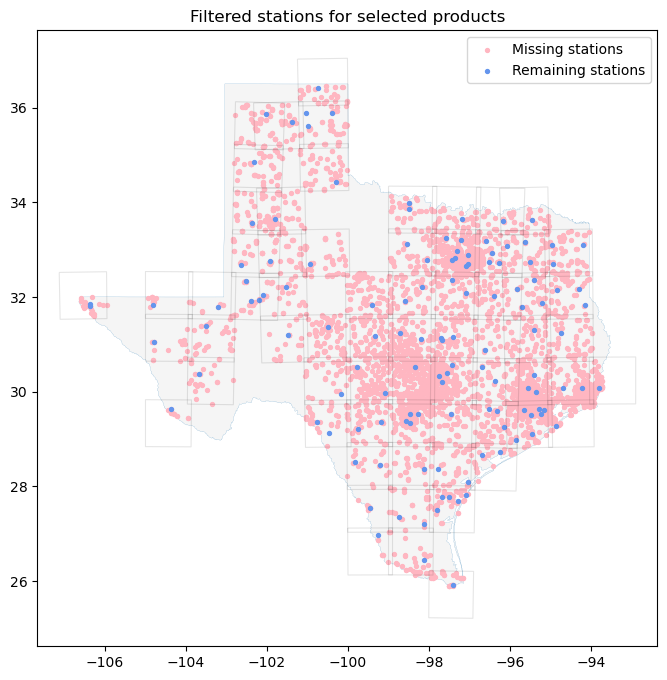

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Filtered stations for selected products')
plot_area_of_interest(ax, 'whitesmoke')
remaining_grid_cells_metars.plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.1, linewidth=0.8, zorder=2)
missing_stations_metadata.sjoin(remaining_grid_cells_metars).plot(ax=ax, marker='o', color='lightpink', markersize=8, alpha=1, label='Missing stations')
stations_metadata.loc[remaining_stations].plot(ax=ax, marker='o', color='cornflowerblue', markersize=8, label='Remaining stations')
ax.legend()

In [36]:
products_filtered = sentinel_products_metadata.loc[metars_per_product.groups.keys()]
print('After filtering for the presence of cloud data in METARs and station containment in product footprint,\n'
      f'{len(products_filtered)} of {len(products_range_selection)} products remain '
      f'[{float(len(products_filtered)) / float(len(products_range_selection)) * 100.0:.1f} %]')

After filtering for the presence of cloud data in METARs and station containment in product footprint,
2824 of 4645 products remain [60.8 %]


In [37]:
products_filtered.index

Index(['00007283-0b01-4764-a8b2-e2379f37028f',
       '0005d67b-d282-4a1d-9e9f-cd6585241657',
       '00096b08-8b91-411a-8195-734996580ca2',
       '0054147d-0b99-4f1e-a122-ee5f3f8dd67e',
       '0062a150-5d82-4ad7-af59-f406bbd7f8c0',
       '006a7945-1ac8-40e9-86eb-b6da6acba50e',
       '007ff2d7-276e-4b3a-9408-45f8bf7ff7ed',
       '00b63f22-f8b3-4a17-801e-cdb8500461aa',
       '00c77525-59e0-4496-8a60-180aca8f3193',
       '00f89da0-a6e7-48d1-80ab-b4161210a6a2',
       ...
       'fedabbb4-9a8e-485f-8305-a36da7282e4f',
       'fef27eb8-8c93-444b-b056-08914f630541',
       'fef5592d-47fd-4204-b8e1-53065ebf040f',
       'ff4deeb8-75e7-4843-8faf-5e59adfcd1f3',
       'ff691452-4329-4669-bf83-c5e9856567df',
       'ffc6975c-dafc-4219-983a-e181e6d07e32',
       'ffd2f23c-d37f-406f-a730-2e7597690168',
       'ffd5bab3-4250-44ef-837f-04e213a66586',
       'ffd7c508-0a7d-4185-9ce8-511fc421d012',
       'fff52610-ce95-4c6b-9ebc-5d6912f0ff3d'],
      dtype='object', length=2824)

In [38]:
products_filtered[['beginposition', 'generationdate']].iloc[0]

beginposition    2023-02-24 17:33:11.024000+00:00
generationdate          2023-02-24 21:15:31+00:00
Name: 00007283-0b01-4764-a8b2-e2379f37028f, dtype: datetime64[ns, UTC]

In [39]:
pd.set_option('display.max_colwidth', None)
metars_per_product.get_group(products_filtered.index[0])[['station', 'datetime', 'sky_conditions [M]', 'product_id']]

,station,datetime,sky_conditions [M],product_id
6635,E38,2023-02-24 17:15:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00007283-0b01-4764-a8b2-e2379f37028f
6636,E38,2023-02-24 17:35:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00007283-0b01-4764-a8b2-e2379f37028f
6637,E38,2023-02-24 17:55:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00007283-0b01-4764-a8b2-e2379f37028f


<Axes: >

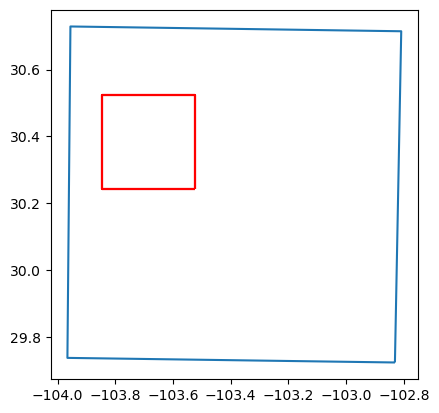

In [40]:
fig, ax = plt.subplots()
product_id_to_plot = products_filtered.index[0]
gpd.GeoDataFrame(pd.DataFrame(sentinel_products_metadata.loc[product_id_to_plot]).T).boundary.plot(ax=ax)
stations_metadata.loc[metars_per_product.get_group(product_id_to_plot)['station']]['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds).boundary
).plot(ax=ax, color='red')

In [41]:
run_cleanup = True

if run_cleanup:
    product_files_local = pd.Series(os.listdir(features_dir))
    products_local = product_files_local.apply(lambda x: Path(x).stem)
    products_to_clean = products_local[~products_local.isin(products_filtered.index)]
    products_to_clean_percentage = 0.0
    if products_local.shape[0] != 0:
        products_to_clean_percentage = products_to_clean.shape[0] / products_local.shape[0] * 100.0
    print(f'{products_to_clean.shape[0]} of {products_local.shape[0]} products are not needed and will be removed'
          f' [{products_to_clean_percentage:.1f} %]')
    for product in products_to_clean:
        for file in product_files_local[product_files_local.str.startswith(product)]:
            os.remove(os.path.join(features_dir, file))

0 of 2143 products are not needed and will be removed [0.0 %]


In [42]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
bands = ['B02', 'B03', 'B04', 'B11']

os.makedirs(features_dir, exist_ok=True)
if 'state' not in products_filtered.columns:
    products_filtered['state'] = QueryStates.NEW
available_product_ids = [Path(file).stem for file in os.listdir(features_dir)]
products_filtered.loc[available_product_ids, 'state'] = QueryStates.AVAILABLE
products_to_download = products_filtered[~products_filtered['state'].isin(
    [QueryStates.AVAILABLE, QueryStates.INVALID, QueryStates.PROCESSED, QueryStates.UNAVAILABLE]
)]
print(f'{products_to_download.shape[0]} of {products_filtered.shape[0]} products are missing'
      f' [{products_to_download.shape[0] / products_filtered.shape[0] * 100.0:.1f} %]')
num_products_ignore = products_filtered.shape[0] - products_to_download.shape[0]
for product_id in tqdm(products_to_download.index, initial=num_products_ignore, total= products_filtered.shape[0]):
    if any(filter(lambda path: path == product_id, available_product_ids)):
        # Skip existing files and directories
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue

    product_state = satellite_client.requestProduct(product_id, copernicus_login)
    products_filtered.at[product_id, 'state'] = product_state
    if product_state != QueryStates.AVAILABLE:
        continue

    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    time.sleep(1)

681 of 2824 products are missing [24.1 %]


 76%|#######5  | 2143/2824 [00:00<?, ?it/s]

In [43]:
products_filtered.groupby(['state'])['state'].count()

state
QueryStates.AVAILABLE      2755
QueryStates.NEW              49
QueryStates.PENDING          19
QueryStates.UNAVAILABLE       1
Name: state, dtype: int64

In [44]:
available_products = products_filtered[products_filtered['state'] == QueryStates.AVAILABLE]
print(f'{available_products.shape[0]} of {products_filtered.shape[0]} products are available [\
{float(available_products.shape[0]) / float(products_filtered.shape[0]) * 100.0:.1f} %]')

2755 of 2824 products are available [97.6 %]


In [45]:
available_products['beginposition']

00007283-0b01-4764-a8b2-e2379f37028f   2023-02-24 17:33:11.024000+00:00
0005d67b-d282-4a1d-9e9f-cd6585241657   2023-02-20 17:03:29.024000+00:00
00096b08-8b91-411a-8195-734996580ca2   2023-01-15 17:36:51.024000+00:00
0054147d-0b99-4f1e-a122-ee5f3f8dd67e   2023-05-06 16:58:51.024000+00:00
0062a150-5d82-4ad7-af59-f406bbd7f8c0   2023-04-01 16:58:49.024000+00:00
                                                     ...               
ffc6975c-dafc-4219-983a-e181e6d07e32   2023-03-17 17:00:31.024000+00:00
ffd2f23c-d37f-406f-a730-2e7597690168   2023-06-04 17:29:01.025000+00:00
ffd5bab3-4250-44ef-837f-04e213a66586   2023-03-06 17:32:01.024000+00:00
ffd7c508-0a7d-4185-9ce8-511fc421d012   2023-03-14 16:50:51.024000+00:00
fff52610-ce95-4c6b-9ebc-5d6912f0ff3d   2023-01-16 17:06:41.024000+00:00
Name: beginposition, Length: 2755, dtype: datetime64[ns, UTC]